In [1]:
!pip install pandahouse -q

  Preparing metadata (setup.py) ... done


In [2]:
import pandahouse as ph
import pandas as pd

In [3]:
connection = dict(database='default',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student-rw',
                  password='656e2b0c9c')


In [4]:
def select(sql):
    return ph.read_clickhouse(sql, connection=connection)

In [ ]:
sql = '''select * from test.installs limit 1000'''

In [ ]:
select(sql)

ClickhouseException: ignored

In [ ]:
df = select(sql)

In [ ]:
from IPython.utils.sysinfo import encoding
df.to_excel('/content/drive/MyDrive/Karpov_Courses/data/ch_data.xlsx', sheet_name='Data', index=False, encoding='utf-8')

/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


In [ ]:
df_in = pd.read_csv('/content/drive/MyDrive/Karpov_Courses/data/medium.csv', sep='\t')

In [ ]:
df_in

,published,domain,url
0,2012-08-13 22:54:53.510Z,medium.com,https://medium.com/policy/medium-terms-of-serv...
1,2012-08-13 22:57:17.248Z,medium.com,https://medium.com/policy/medium-privacy-polic...
2,2016-11-04 23:40:43.364Z,medium.com,https://medium.com/@Medium/personalize-your-me...
3,2016-12-24 18:21:13.427Z,medium.com,https://medium.com/holiday-poems/xmas-morning-...
4,2015-09-22 21:37:48.207Z,blog.medium.com,https://blog.medium.com/taking-a-side-on-net-n...
...,...,...,...
92186,2017-05-23 17:15:09.193Z,medium.com,https://medium.com/@KyleAndrews1994/its-time-t...
92187,2017-01-31 09:59:12.316Z,medium.com,https://medium.com/silent-protagonist/next-wee...
92188,2017-02-16 14:15:20.116Z,medium.com,https://medium.com/@utapartment26/there-used-t...
92189,2017-06-27 10:16:21.668Z,medium.com,https://medium.com/silent-protagonist/the-snes...


In [ ]:
sql_create = '''
CREATE TABLE test.i_fed (
  published String,
  domain String,
  url String
)
engine = Log'''

In [ ]:
sql_drop = '''drop table test.i_fed'''
ph.execute(sql_drop, connection=connection)

b''

In [ ]:
ph.execute(sql_create, connection=connection)

b''

In [ ]:
ph.execute(sql_create, connection=connection)

In [ ]:
select(sql_create)

UnicodeDecodeError: ignored

In [ ]:
sql = '''select * from test.i_fed'''

In [ ]:
select(sql)

,published,domain,url


In [ ]:
ph.to_clickhouse(df_in, 'test.i_fed', index=False, connection=connection)

ClickhouseException: ignored

In [ ]:
df_in

,published,domain,url
0,2012-08-13 22:54:53.510Z,medium.com,https://medium.com/policy/medium-terms-of-serv...
1,2012-08-13 22:57:17.248Z,medium.com,https://medium.com/policy/medium-privacy-polic...
2,2016-11-04 23:40:43.364Z,medium.com,https://medium.com/@Medium/personalize-your-me...
3,2016-12-24 18:21:13.427Z,medium.com,https://medium.com/holiday-poems/xmas-morning-...
4,2015-09-22 21:37:48.207Z,blog.medium.com,https://blog.medium.com/taking-a-side-on-net-n...
...,...,...,...
92186,2017-05-23 17:15:09.193Z,medium.com,https://medium.com/@KyleAndrews1994/its-time-t...
92187,2017-01-31 09:59:12.316Z,medium.com,https://medium.com/silent-protagonist/next-wee...
92188,2017-02-16 14:15:20.116Z,medium.com,https://medium.com/@utapartment26/there-used-t...
92189,2017-06-27 10:16:21.668Z,medium.com,https://medium.com/silent-protagonist/the-snes...


### Временные ряды

In [2]:
!pip install prophet -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 3.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import pandahouse as ph
from datetime import date
import holidays
from prophet import Prophet

In [4]:
connection = dict(database='default',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student-rw',
                  password='656e2b0c9c')

In [7]:
def select(sql):
    return ph.read_clickhouse(sql, connection=connection)

In [15]:
sql = '''
SELECT
  ds,
  count(distinct(DeviceID)) as y
FROM test.installs
WHERE
  Source = 'Source_27'
  and
  InstallCost = 0
group by CAST(InstallationDate as Date) as ds
order by ds asc
'''

In [16]:
df = select(sql)
df['ds'] = pd.to_datetime(df['ds'])

In [17]:
df

,ds,y
0,2019-01-01,26243
1,2019-01-02,31303
2,2019-01-03,34017
3,2019-01-04,33807
4,2019-01-05,33925
...,...,...
272,2019-09-30,19028
273,2019-10-01,19176
274,2019-10-02,18926
275,2019-10-03,18373


In [22]:
holidays_dict = holidays.RU(years=(2015, 2016, 2017, 2018, 2019, 2020, 2021))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index').reset_index()
df_holidays = df_holidays.rename({'index': 'ds', 0: 'holiday'}, axis='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays['ds'])
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays.tail()

,ds,holiday
93,2021-03-08,International Women's Day
94,2021-05-01,Holiday of Spring and Labor
95,2021-05-09,Victory Day
96,2021-06-12,Russia's Day
97,2021-11-04,Unity Day


In [23]:
predictions = 30

train_df = df[:-predictions]

In [25]:
m = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
m.fit(train_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h4mz04o/pbp6e9nf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h4mz04o/sni5r6wl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58863', 'data', 'file=/tmp/tmp6h4mz04o/pbp6e9nf.json', 'init=/tmp/tmp6h4mz04o/sni5r6wl.json', 'output', 'file=/tmp/tmp6h4mz04o/prophet_model4_dipmpe/prophet_model-20230503105040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:50:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:50:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [30]:
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

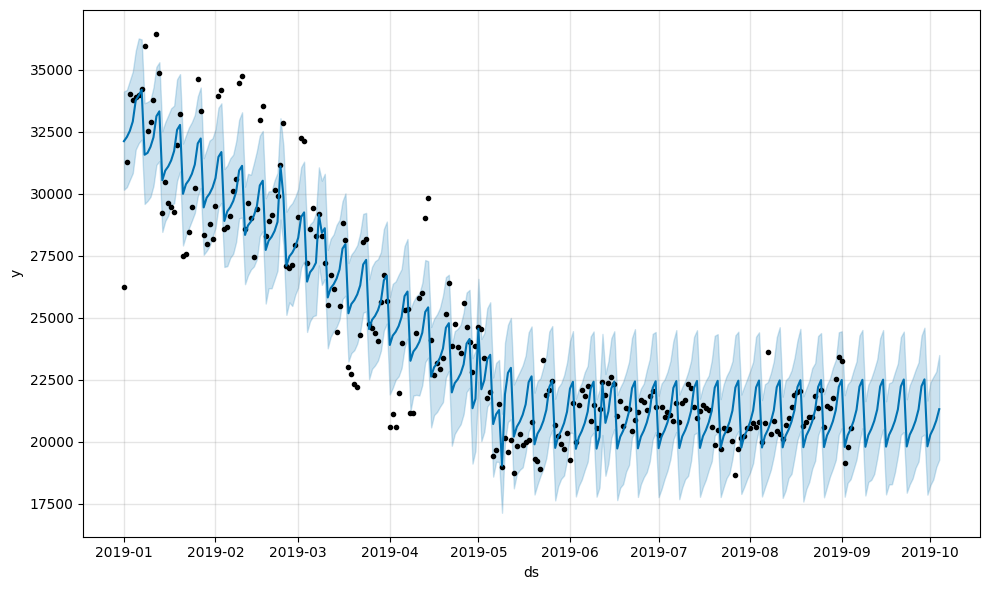

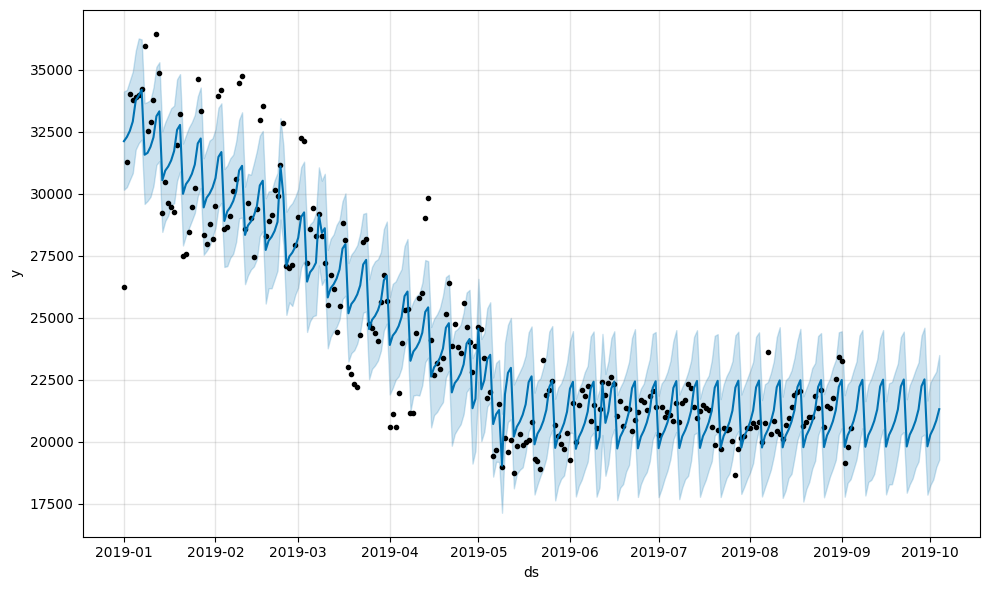

In [31]:
m.plot(forecast)

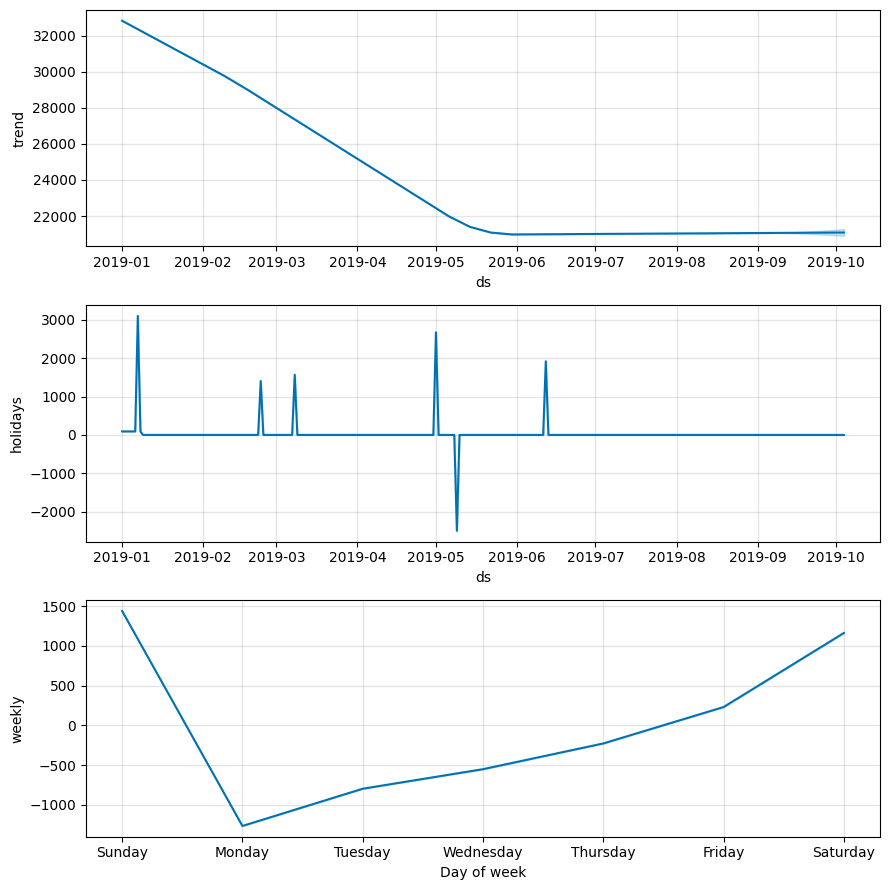

In [32]:
# Смотрим на сезонности
m.plot_components(forecast);

In [ ]:
# Рисуем график с границами прогноза
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='prediction'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='trend')
])

In [34]:
# Смотрим на ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  5.602431543971838 %
MAE (средняя абсолютная ошибка) –  1087.3790379189095


In [35]:
# Прогнозируем на полный период (указываем количество дней)
prediction_days = 90
final_train_df = df
f = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
f.fit(final_train_df)
final_future = f.make_future_dataframe(periods=prediction_days)
final_forecast = f.predict(final_future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h4mz04o/u5sk0u74.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h4mz04o/qqsn146r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68911', 'data', 'file=/tmp/tmp6h4mz04o/u5sk0u74.json', 'init=/tmp/tmp6h4mz04o/qqsn146r.json', 'output', 'file=/tmp/tmp6h4mz04o/prophet_modelpn5rapob/prophet_model-20230503105440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:54:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:54:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


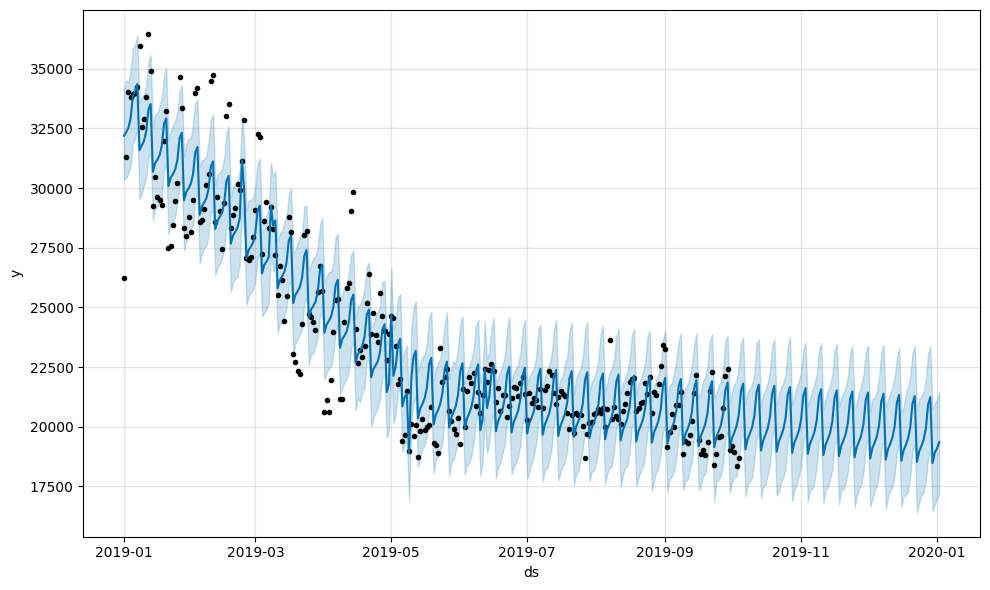

In [36]:
# Смотрим, что предсказалось на полный период
f.plot(final_forecast);

In [37]:
# Рисуем график с границами прогноза на полном периоде
iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat'], name='yhat'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['trend'], name='trend')
])

In [38]:
# Выгружаем прогноз в эксельку. Спрогнозированное значение лежит в столбце yhat
final_forecast.to_excel("./app_forecast.xlsx", sheet_name='Data', index=False, encoding="cp1251")

/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: FutureWarning:

the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'

